In [1]:
import time
import math
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn import preprocessing
import recommender
import imp

In [2]:
from evaluation import *

In [3]:
SUBMISSION = False
SUBMISSION_FILENAME = 'submission.csv'
TEST_FILENAME = 'test.csv'

In [4]:
target_playlists = pd.read_csv('../../datasets/target_playlists.csv', sep='\t')
target_tracks = pd.read_csv('../../datasets/target_tracks.csv', sep='\t')
tracks_final = pd.read_csv('../../datasets/tracks_final.csv', sep='\t')
playlists_final = pd.read_csv('../../datasets/playlists_final.csv', sep='\t')
train_final = pd.read_csv('../../datasets/train_final.csv', sep='\t')

print('Successfully read data')

Successfully read data


In [5]:
print('Data info:')
print('Unique tracks count: {}'.format(tracks_final['track_id'].nunique()))
print('Unique playlist count: {}'.format(playlists_final['playlist_id'].nunique()))
print('Target tracks count: {}'.format(target_tracks['track_id'].nunique()))
print('Target playlists count: {}'.format(target_playlists['playlist_id'].nunique()))

Data info:
Unique tracks count: 100000
Unique playlist count: 57561
Target tracks count: 32195
Target playlists count: 10000


In [6]:
track_id_le = preprocessing.LabelEncoder()
track_id_le.fit(list(tracks_final['track_id']))
print('track_id_le classes: {}'.format(len(track_id_le.classes_)))

playlist_id_le = preprocessing.LabelEncoder()
playlist_id_le.fit(list(playlists_final['playlist_id']))
print('playlist_id_le classes: {}'.format(len(playlist_id_le.classes_)))

track_id_le classes: 100000
playlist_id_le classes: 57561


In [7]:
# Playlist and tracks that belong to them
target_playlists_and_tracks = pd.merge(target_playlists, train_final, on='playlist_id')
print('target_playlists_and_tracks {}'.format(target_playlists_and_tracks.shape))
print(target_playlists_and_tracks.head(10))

target_playlists_and_tracks (362661, 2)
   playlist_id  track_id
0     10024884   2879006
1     10024884   1532328
2     10024884   3027673
3     10024884   3236144
4     10024884   1563134
5     10024884    435345
6     10024884    353291
7     10024884    247331
8     10024884    161455
9     10024884   3338954


In [8]:
def split_training_data(train_final, target_playlists_and_tracks, random_state):
    validation_set = target_playlists_and_tracks.groupby(['playlist_id'])\
                        .apply(lambda x: x.sample(n=3, random_state=random_state))\
                        .reset_index(drop=True)
    df_concat = pd.concat([train_final, validation_set])
    training_set = df_concat.drop_duplicates(keep=False)
    return training_set, validation_set

# Split dataset - from all target playlists remove randomly 3 tracks
training_set, validation_set = split_training_data(train_final, target_playlists_and_tracks, random_state=5)
test_target_tracks = validation_set['track_id'].drop_duplicates(keep='first').to_frame()
test_target_tracks['transformed_track_id'] = track_id_le.transform(list(test_target_tracks['track_id']))
target_tracks['transformed_track_id'] = track_id_le.transform(list(target_tracks['track_id']))
target_playlists['transformed_playlist_id'] = playlist_id_le.transform(list(target_playlists['playlist_id']))

training_set['transformed_track_id'] = track_id_le.transform(list(training_set['track_id']))
training_set['transformed_playlist_id'] = playlist_id_le.transform(list(training_set['playlist_id']))

train_final['transformed_track_id'] = track_id_le.transform(list(train_final['track_id']))
train_final['transformed_playlist_id'] = playlist_id_le.transform(list(train_final['playlist_id']))

print('training_set: {}'.format(training_set.shape))
print(training_set.head(5))
print('validation_set: {}'.format(validation_set.shape))
print(validation_set.head(5))
print('test_target_tracks: {}'.format(test_target_tracks.shape))
print(test_target_tracks.head(5))

training_set: (1010522, 4)
   playlist_id  track_id  transformed_track_id  transformed_playlist_id
0      3271849   2801526                 71058                     8890
1      5616275    727878                 19741                    22426
2     11267488   2805283                 71298                    54743
3     10103900   1515105                 36851                    46970
4      3836898   2945623                 76310                    11967
validation_set: (30000, 2)
   playlist_id  track_id
0         7614   1609224
1         7614   1614974
2         7614   3711434
3         7692   1232748
4         7692     88210
test_target_tracks: (21929, 2)
   track_id  transformed_track_id
0   1609224                 39285
1   1614974                 39451
2   3711434                 94876
3   1232748                 30527
4     88210                  1566


In [9]:
urm_train_ones = np.ones(training_set.shape[0])
print('urm_train_ones shape: {}, vector: {}'.format(urm_train_ones.shape, urm_train_ones))

URM_train = scipy.sparse.coo_matrix((urm_train_ones, (list(training_set['transformed_playlist_id']),
                                                      list(training_set['transformed_track_id']))))
print(type(URM_train))
print(URM_train.shape)
playlists_per_track = (URM_train > 0).sum(axis=0)
tracks_per_playlist = (URM_train > 0).sum(axis=1)

print('playlists_per_track.shape {}'.format(playlists_per_track.shape))
print('tracks_per_playlist.shape {}'.format(tracks_per_playlist.shape))

urm_train_ones shape: (1010522,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
<class 'scipy.sparse.coo.coo_matrix'>
(57561, 100000)
playlists_per_track.shape (1, 100000)
tracks_per_playlist.shape (57561, 1)


In [10]:
urm_test_ones = np.ones(train_final.shape[0])
print('urm_test_ones shape: {}, vector: {}'.format(urm_test_ones.shape, urm_test_ones))

URM_test = scipy.sparse.coo_matrix((urm_test_ones, (list(train_final['transformed_playlist_id']),
                                                    list(train_final['transformed_track_id']))))
print(type(URM_train))
print(URM_train.shape)

urm_test_ones shape: (1040522,), vector: [ 1.  1.  1. ...,  1.  1.  1.]
<class 'scipy.sparse.coo.coo_matrix'>
(57561, 100000)


In [11]:
playlists_per_track = np.array(playlists_per_track).squeeze()
tracks_per_playlist = np.array(tracks_per_playlist).squeeze()

print(playlists_per_track.shape)
print(tracks_per_playlist.shape)

playlists_per_track = np.sort(playlists_per_track)
tracks_per_playlist = np.sort(tracks_per_playlist)

(100000,)
(57561,)


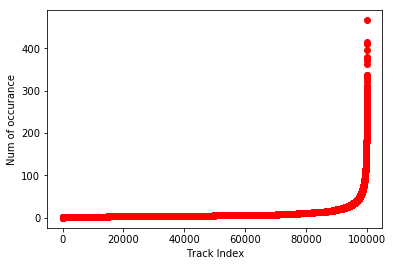

In [12]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(playlists_per_track, 'ro')
pyplot.ylabel('Num of occurance')
pyplot.xlabel('Track Index')
pyplot.show()

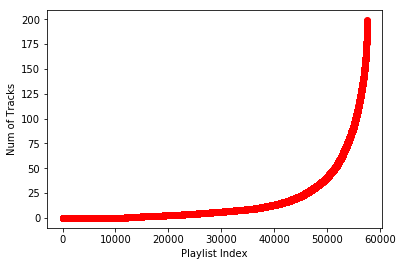

In [13]:
pyplot.plot(tracks_per_playlist, 'ro')
pyplot.ylabel('Num of Tracks')
pyplot.xlabel('Playlist Index')
pyplot.show()

In [14]:
URM_mask = URM_train.copy().tocsr()
print('URM_mask before: {}'.format(len(URM_mask.data)))
URM_mask.eliminate_zeros()
print('URM_mask after: {}'.format(len(URM_mask.data)))

print('URM_mask shape: {}'.format(URM_mask.shape))
URM_mask

URM_mask before: 1010522
URM_mask after: 1010522
URM_mask shape: (57561, 100000)


<57561x100000 sparse matrix of type '<class 'numpy.float64'>'
	with 1010522 stored elements in Compressed Sparse Row format>

In [17]:
imp.reload(recommender)
print('Building model...')
begin = time.time()
rec = recommender.SLIM_BPR_Recommender_Cython_User(URM_train, test_target_tracks, test_target_tracks, target_playlists, track_id_le, training_set, sgd_mode='sgd')
# rec = recommender.SLIM_BPR_Recommender_Cython_User(URM_test, test_target_tracks, target_tracks, target_playlists, track_id_le, training_set, sgd_mode='sgd')
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

Building model...
Took 0.48767s


In [18]:
print('Training model...')
begin = time.time()
rec.fit(epochs=5, learning_rate=0.00001, batch_size=1, target_playlists=target_playlists.head(300), validation_set=validation_set,\
        topK=20, validate_every_n_epochs=1, lambda_i=0.002, lambda_j=0.0002)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=3))

Training model...
Processed 500000 ( 49.48% ) in 11.38 seconds. Sample per second: 43944
Processed 1000000 ( 98.96% ) in 12.16 seconds. Sample per second: 43169
Processed 1010522 ( 100.00% ) in 0.47 seconds. Sample per second: 43063
Epoch 1 of 5 complete in 0.46 minutes
Processed 500000 ( 49.48% ) in 10.45 seconds. Sample per second: 47827
Processed 1000000 ( 98.96% ) in 11.32 seconds. Sample per second: 46908
Processed 1010522 ( 100.00% ) in 0.57 seconds. Sample per second: 46852
Evaluation begins...
Test case: {'epoch': 2, 'lambda_j': 0.0002, 'batch': 1, 'lambda_i': 0.002, 'topK': 20, 'learn_rate': 1e-05}

Precision: 0.02000, mAP: 0.02667, took 25.41497s
Epoch 2 of 5 complete in 0.86 minutes
Processed 500000 ( 49.48% ) in 10.89 seconds. Sample per second: 45921
Processed 1000000 ( 98.96% ) in 12.02 seconds. Sample per second: 45407
Processed 1010522 ( 100.00% ) in 0.27 seconds. Sample per second: 45379
Evaluation begins...
Test case: {'epoch': 3, 'lambda_j': 0.0002, 'batch': 1, 'lamb

In [21]:
print('Recommending...')
begin = time.time()
recommended_items = rec.recommend(target_playlists.head(300), k=15)
print('Took {0:.{digits}f}s'.format(time.time() - begin, digits=5))

print('recommended_items {}'.format(recommended_items.shape))
print(recommended_items.head(3))

Recommending...
Took 44.37967s
recommended_items (300, 4)
   playlist_id  transformed_playlist_id               recommendation  \
0     10024884                    46297   [897771, 2971366, 3779477]   
1     10624787                    50898  [2127224, 1563309, 2639723]   
2      4891851                    17907   [2258669, 3554829, 498625]   

                                              scores  
0  [0.000854708017109, 0.000854708017109, 0.00081...  
1  [0.000529918001727, 0.000529899777086, 0.00042...  
2  [0.000564830886786, 0.000564830886786, 0.00056...  


In [22]:
if not SUBMISSION:
    evaluate(recommended_items, validation_set)

Evaluating...
Precision: 0.02556, mAP: 0.03074, took 0.44001s


In [23]:
scipy.sparse.save_npz('slim_user_20_5', rec.W_sparse)

In [49]:
# print(type(recommender.W_sparse))
scipy.sparse.save_npz('slim_150_2', recommender.W_sparse)

In [40]:
def print_results(recommended_items, filename):
    print('Printing...')
    with open('../submissions/hybrid{}'.format(filename), 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, recommendation in recommended_items.iterrows():
            row = '{},'.format(recommendation['playlist_id'])
            for track_id in pd.Series(recommendation['recommendation']).values:
                row += ' {}'.format(track_id)
            row += '\n'
            output_file.write(row)
print_results(recommended_items, filename=SUBMISSION_FILENAME if SUBMISSION else TEST_FILENAME)

Printing...


In [56]:
def print_validation_set(validation_set):
    print('Printing...')
    with open('./submissions/validationset.csv', 'w') as output_file:
        output_file.write('playlist_id,track_ids\n')
        for index, validation_row in validation_set.iterrows():
            if index % 3 == 0:
                playlist_id = '{},'.format(validation_row['playlist_id'])
                output_file.write(playlist_id)
            track_id = ' {}'.format(validation_row['track_id'])
            output_file.write(track_id)

            if index % 3 == 2:
                output_file.write('\n')
print_validation_set(validation_set)

Printing...
